In [1]:
# -------------------------------
# Improved Credit Risk Model for Canadian Steel Sector
# Fixed: Data leakage, added lagged features, better evaluation
# Author: Mohsen Selseleh (Adapted)
# -------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# =========================
# Step 1: Load & Clean Data
# =========================
df_monthly = pd.read_csv("Table 12-10-0121-01.csv", skiprows=10, header=1)
monthly_imports_raw = df_monthly.iloc[0, 3:]
monthly_imports = monthly_imports_raw.T.reset_index()
monthly_imports.columns = ['Month', 'Import_Value_MillionCAD']
monthly_imports['Month'] = pd.date_range(start='2016-01-01', periods=len(monthly_imports), freq='MS')
monthly_imports['Import_Value_MillionCAD'] = (
    monthly_imports['Import_Value_MillionCAD']
    .astype(str)
    .str.replace(",", "")
    .astype(float)
)

# =============================
# Step 2: Feature Engineering (Lagged, No Leakage)
# =============================
df = monthly_imports.copy()
df = df.sort_values('Month').reset_index(drop=True)

# Target: Stress = sharp MoM drop (but NOT use MoM_Change as feature!)
df['MoM_Change'] = df['Import_Value_MillionCAD'].pct_change()
df['StressFlag'] = (df['MoM_Change'] < -0.10).astype(int)  # Label: >10% drop

# Lagged features (only past info used to predict current stress)
df['Import_Lag1'] = df['Import_Value_MillionCAD'].shift(1)
df['Import_Lag2'] = df['Import_Value_MillionCAD'].shift(2)
df['YoY_Change'] = df['Import_Value_MillionCAD'].pct_change(periods=12).fillna(0)
df['Volatility_3M'] = df['MoM_Change'].rolling(3).std().fillna(0)
df['Trend_Slope'] = (df['Import_Lag1'] - df['Import_Lag2'])  # momentum

# Tariff period (post-March 2018)
df['TariffPeriod'] = (df['Month'] >= '2018-03-01').astype(int)

# Drop rows with NaN (due to lag/rolling)
df = df.dropna(subset=['Import_Lag1', 'Import_Lag2', 'Volatility_3M'])

# =============================
# Step 3: Feature Selection (NO MoM_Change in features!)
# =============================
features = [
    'Import_Lag1',
    'Import_Lag2',
    'YoY_Change',
    'Volatility_3M',
    'Trend_Slope',
    'TariffPeriod'
]
X = df[features]
y = df['StressFlag']

# Time-based split (no shuffling)
split_idx = int(0.8 * len(df))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training periods: {len(X_train)} months | Test: {len(X_test)} months")
print(f"Stress events in test: {y_test.sum()} out of {len(y_test)}")

Training periods: 46 months | Test: 12 months
Stress events in test: 2 out of 12


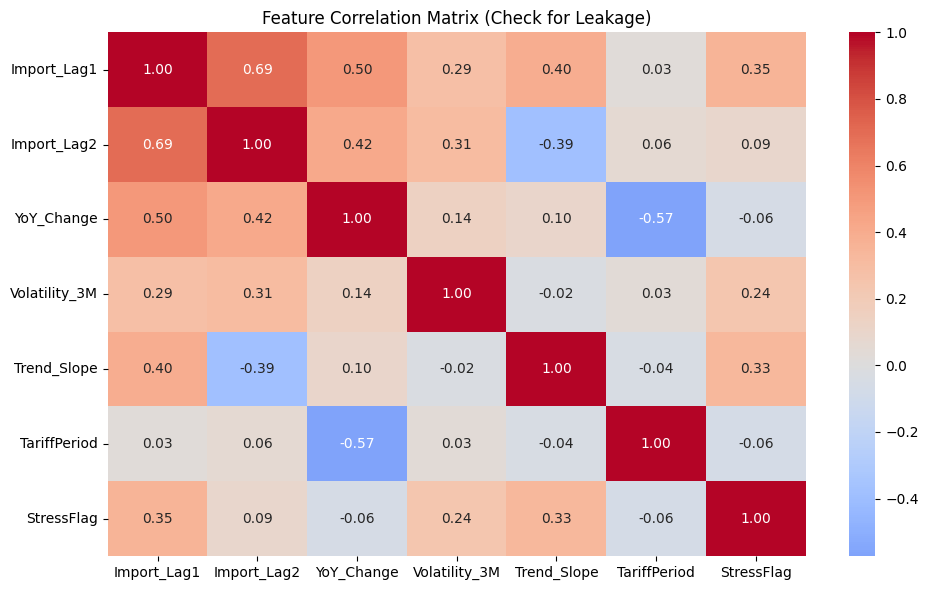

In [2]:
# Correlation heatmap to detect leakage or high correlation
plt.figure(figsize=(10, 6))
correlation_matrix = df[features + ['StressFlag']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title("Feature Correlation Matrix (Check for Leakage)")
plt.tight_layout()
plt.savefig("correlation_heatmap.png", dpi=300)
plt.show()

In [3]:
# Logistic Regression (scaled)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logit = LogisticRegression(random_state=42)
logit.fit(X_train_scaled, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Predict probabilities
y_proba_logit = logit.predict_proba(X_test_scaled)[:, 1]
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Evaluate
print("✅ Logistic Regression AUC:", roc_auc_score(y_test, y_proba_logit))
print("✅ Random Forest AUC:", roc_auc_score(y_test, y_proba_rf))

✅ Logistic Regression AUC: 0.65
✅ Random Forest AUC: 0.5


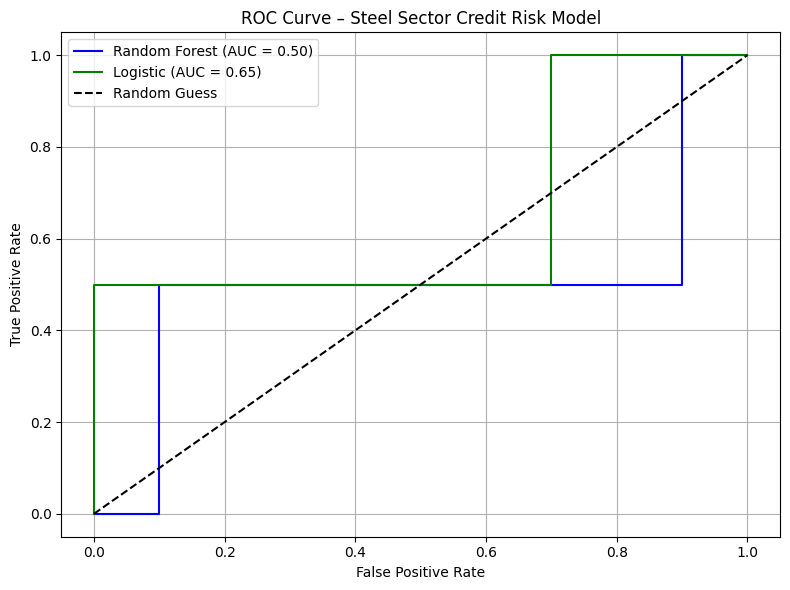

In [4]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_logit, tpr_logit, _ = roc_curve(y_test, y_proba_logit)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf):.2f})", color='blue')
plt.plot(fpr_logit, tpr_logit, label=f"Logistic (AUC = {roc_auc_score(y_test, y_proba_logit):.2f})", color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Steel Sector Credit Risk Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_corrected.png", dpi=300)
plt.show()

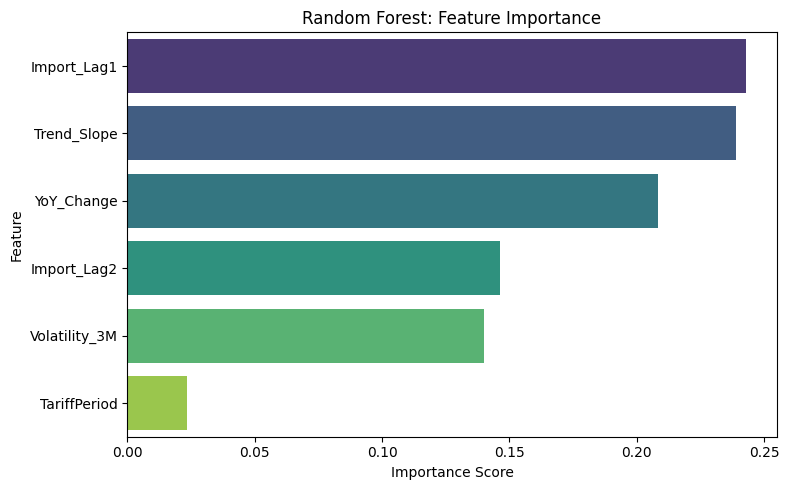

         Feature  Importance
0    Import_Lag1    0.242833
4    Trend_Slope    0.239136
2     YoY_Change    0.208408
1    Import_Lag2    0.146146
3  Volatility_3M    0.140158
5   TariffPeriod    0.023320


In [5]:
# Random Forest Feature Importance
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Random Forest: Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300)
plt.show()

print(feature_importance_df)

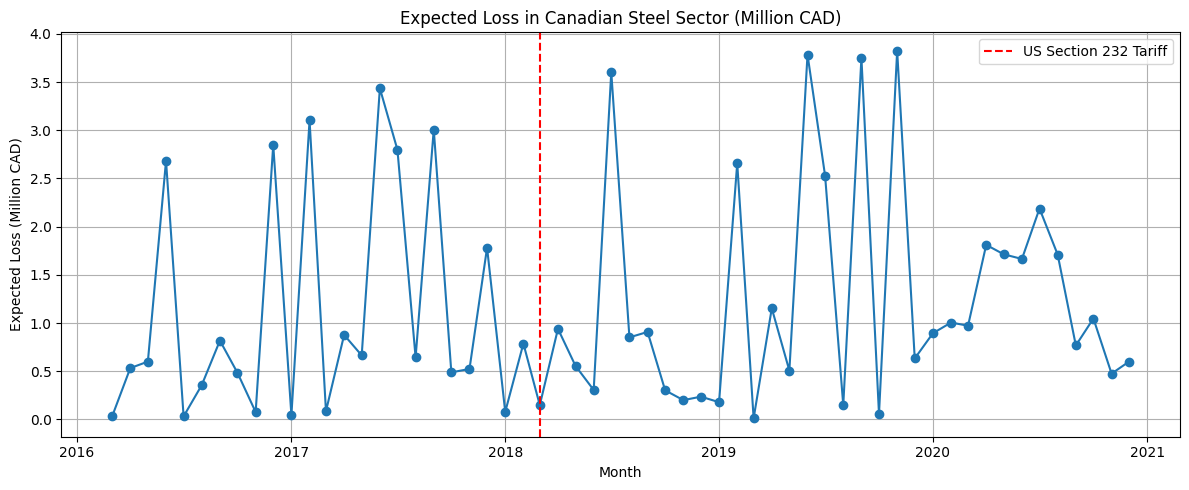

In [6]:
assumed_LGD = 0.45
assumed_EAD = 10_000_000  # CAD

df['PD_RF'] = rf.predict_proba(df[features])[:, 1]
df['Expected_Loss'] = df['PD_RF'] * assumed_LGD * assumed_EAD

plt.figure(figsize=(12, 5))
plt.plot(df['Month'], df['Expected_Loss'] / 1e6, marker='o')
plt.title("Expected Loss in Canadian Steel Sector (Million CAD)")
plt.ylabel("Expected Loss (Million CAD)")
plt.xlabel("Month")
plt.axvline(pd.to_datetime('2018-03-01'), color='red', linestyle='--', label='US Section 232 Tariff')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("expected_loss_timeseries.png", dpi=300)
plt.show()

ADF p Import_pct: 6.903838593688186e-21
ADF p PD_diff: 6.44771822402908e-05
VAR lag (AIC): 1


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


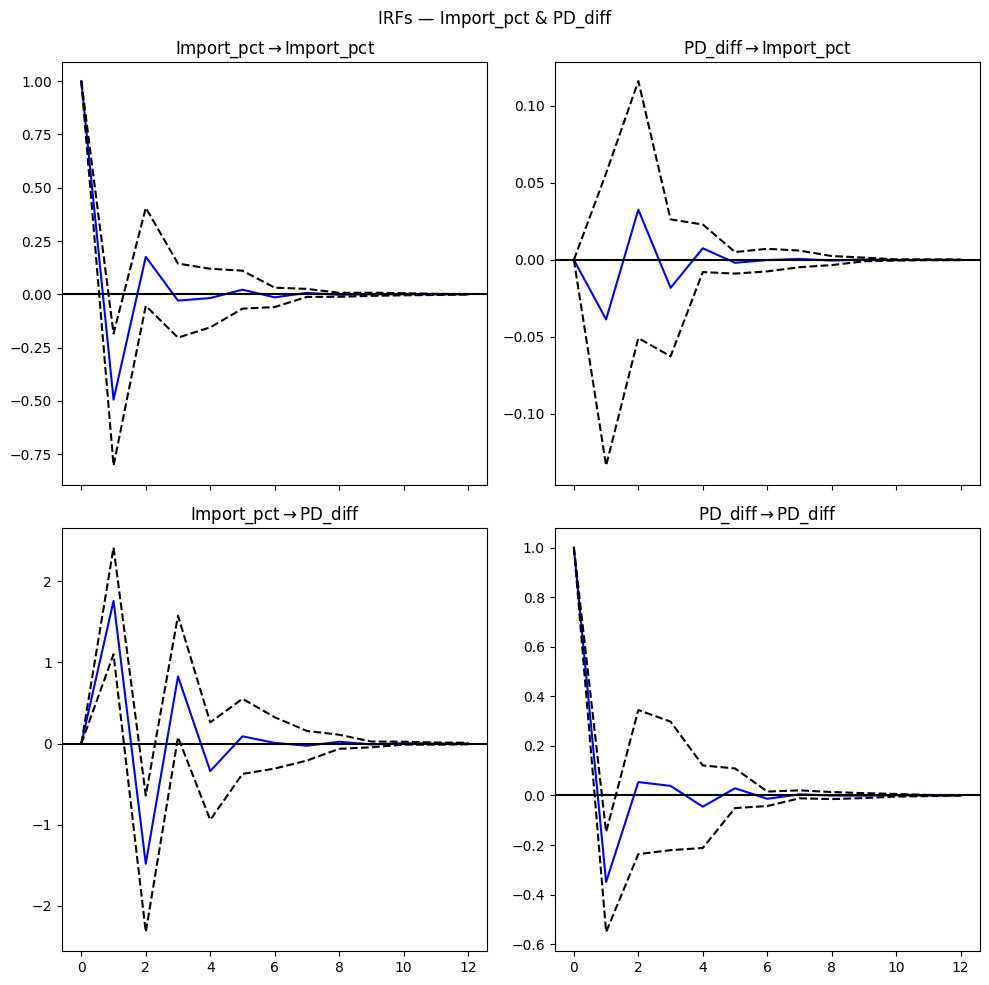


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=27.4463 , p=0.0000  , df_denom=54, df_num=1
ssr based chi2 test:   chi2=28.9711 , p=0.0000  , df=1
likelihood ratio test: chi2=23.4247 , p=0.0000  , df=1
parameter F test:         F=27.4463 , p=0.0000  , df_denom=54, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6385  , p=0.4277  , df_denom=54, df_num=1
ssr based chi2 test:   chi2=0.6740  , p=0.4117  , df=1
likelihood ratio test: chi2=0.6701  , p=0.4130  , df=1
parameter F test:         F=0.6385  , p=0.4277  , df_denom=54, df_num=1


In [8]:
# VAR + Granger (stationary transforms)
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.api import VAR
import os

# Define label_pd and OUT_DIR as they are used but not defined
label_pd = 'PD_RF' # Assuming 'PD_RF' is the column containing Probability of Default
OUT_DIR = './' # Assuming the output directory is the current directory


def adf_p(series):
    series = pd.Series(series).dropna()
    if len(series) < 10:
        return 1.0
    try:
        return adfuller(series, autolag="AIC")[1]
    except Exception:
        return 1.0

ts = df[["Month", "Import_Value_MillionCAD", label_pd]].dropna().copy()
ts["Import_pct"] = ts["Import_Value_MillionCAD"].pct_change().fillna(0.0)
ts["PD_diff"] = ts[label_pd].diff().fillna(0.0)

print("ADF p Import_pct:", adf_p(ts["Import_pct"]))
print("ADF p PD_diff:", adf_p(ts["PD_diff"]))

var_df = ts[["Import_pct", "PD_diff"]]
model = VAR(var_df)
lag_sel = model.select_order(6)
lag = int(lag_sel.aic or 2)
res = model.fit(lag)

print("VAR lag (AIC):", lag)
irf = res.irf(12)
fig = irf.plot(orth=False)
plt.suptitle("IRFs — Import_pct & PD_diff")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "irf_plot.png"), dpi=300)
plt.show()

# Granger: Imports -> PD
g1 = grangercausalitytests(var_df[["PD_diff", "Import_pct"]], maxlag=min(4, lag), verbose=True)
# Granger: PD -> Imports
g2 = grangercausalitytests(var_df[["Import_pct", "PD_diff"]], maxlag=min(4, lag), verbose=True)